# Employee turnover prediction

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from category_encoders import OneHotEncoder
from sklearn.preprocessing import  LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
 
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split,RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [3]:
df=pd.read_csv('Dataset.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

# Explore Data

In [5]:
df[['Attrition']].head(5)

,Attrition
0,Yes
1,No
2,Yes
3,No
4,No


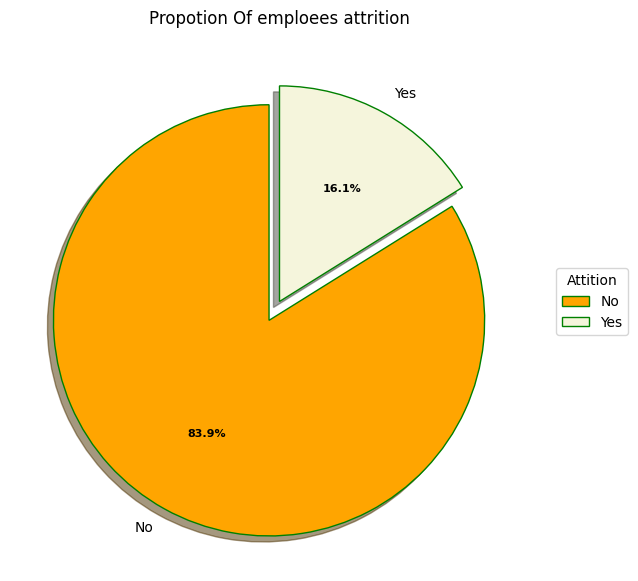

In [6]:
# Creating plot
att=df['Attrition'].value_counts(normalize=True)
explode = (0.1, 0.0, )
 
# Creating color parameters
colors = ( "orange", "beige")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(att,
                                  autopct = lambda pct: func(pct, att),
                                  explode = explode,
                                  labels = att.index,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, att.index,
          title ="Attition",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Propotion Of emploees attrition")
 
# show plot
plt.show()

## Attrition VS Age

In [7]:
df[['Age']].head(5)

,Age
0,41
1,49
2,37
3,33
4,27


In [8]:
age_att=df.groupby(['Age','Attrition'])['Attrition'].count().reset_index(name='Counts')
age_att

,Age,Attrition,Counts
0,18,No,4
1,18,Yes,4
2,19,No,3
3,19,Yes,6
4,20,No,5
...,...,...,...
77,57,No,4
78,58,No,9
79,58,Yes,5
80,59,No,10


## BusinessTravel vs Attrition 

In [11]:
df['BusinessTravel'].value_counts()

BusinessTravel
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: count, dtype: int64

In [12]:
n=df.groupby(['BusinessTravel','Attrition'])['BusinessTravel'].count().reset_index(name='Counts')
n

,BusinessTravel,Attrition,Counts
0,Non-Travel,No,138
1,Non-Travel,Yes,12
2,Travel_Frequently,No,208
3,Travel_Frequently,Yes,69
4,Travel_Rarely,No,887
5,Travel_Rarely,Yes,156


In [13]:
per=np.array([(138/150)*100,(12/150)*100,(208/(208+69))*100,(69/(208+69))*100,(887/(887+156))*100,(156/(887+156))*100]).round(3)
n['Percent']=per

In [14]:
n

,BusinessTravel,Attrition,Counts,Percent
0,Non-Travel,No,138,92.000
1,Non-Travel,Yes,12,8.000
2,Travel_Frequently,No,208,75.090
3,Travel_Frequently,Yes,69,24.910
4,Travel_Rarely,No,887,85.043
5,Travel_Rarely,Yes,156,14.957


## Department vs Attrition

In [17]:
dept_att=df.groupby(['Department','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')
per=np.array([(51/(51+12))*100,(12/(51+12))*100,(828/(828+133))*100,(133/(828+133))*100,(354/(354+93))*100,(93/(354+93))*100]).round(2)
dept_att['Percent']=per

## Daily Rate VS Attrition 

<Axes: title={'center': 'DailyRate'}, ylabel='Attrition'>

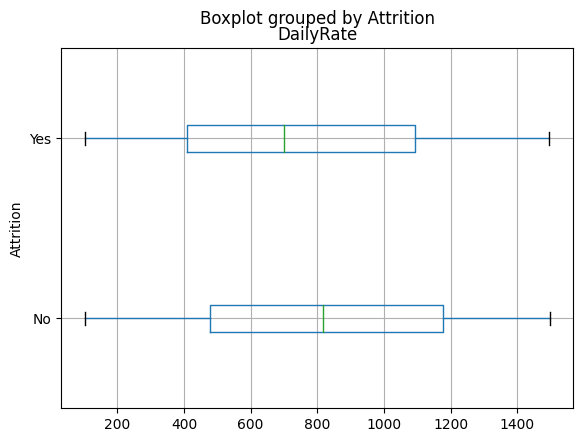

In [20]:
df.boxplot(by= 'Attrition',column='DailyRate',vert=False)


In [21]:
rate_att=df.groupby(['DailyRate','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')


## Distance From Home VS Attrition

In [22]:
df['DistanceFromHome'].head()


0    1
1    8
2    2
3    3
4    2
Name: DistanceFromHome, dtype: int64

In [23]:
dist_att=df.groupby(['DistanceFromHome','Attrition'])['Attrition'].count().reset_index(name='Counts')


## Education VS Attrition

In [25]:
df['Education'].unique()

array([2, 1, 4, 3, 5], dtype=int64)

In [26]:
df['EducationField'].unique()

array(['Life Sciences', 'Other', 'Medical', 'Marketing',
       'Technical Degree', 'Human Resources'], dtype=object)

In [27]:
edu_att=df.groupby(['Education','Attrition'])['Attrition'].count().reset_index(name='Counts')
edu_att[edu_att['Attrition']=='Yes']

,Education,Attrition,Counts
1,1,Yes,31
3,2,Yes,44
5,3,Yes,99
7,4,Yes,58
9,5,Yes,5


In [29]:
perc=np.array([(139/(139+31))*100,(31/(139+31))*100,(238/(238+44))*100,(44/(238+44))*100,
               (473/(473+99))*100,(99/(473+99))*100,(340/(340+58))*100,(58/(340+58))*100
              ,(43/(43+5))*100,(5/(34+5))*100]).round(2)
edu_att['Percent']=perc

In [31]:
eduf_att=df.groupby(['EducationField','Attrition'])['Attrition'].count().reset_index(name='Counts')
eduf_att[eduf_att['Attrition']=='Yes']

,EducationField,Attrition,Counts
1,Human Resources,Yes,7
3,Life Sciences,Yes,89
5,Marketing,Yes,35
7,Medical,Yes,63
9,Other,Yes,11
11,Technical Degree,Yes,32


## Environment Satisfaction VS Attiration 

In [33]:
envs_att=df.groupby(['EnvironmentSatisfaction','Attrition'])['Attrition'].count().reset_index(name='Counts')
envs_att[envs_att['Attrition']=='Yes']

,EnvironmentSatisfaction,Attrition,Counts
1,1,Yes,72
3,2,Yes,43
5,3,Yes,62
7,4,Yes,60


In [34]:
perc_envs=np.array([(212/(212+72))*100,(72/(212+72))*100,(244/(244+43))*100,(43/(244+43))*100,
               (391/(391+62))*100,(62/(391+62))*100,(386/(386+60))*100,(60/(386+60))*100]).round(2)
envs_att['Percent']=perc_envs

## Gender VS Attrition 

In [36]:
gndr_att=df.groupby(['Gender','Attrition'])['Attrition'].count().reset_index(name='Counts')
gndr_att[gndr_att['Attrition']=='Yes']

,Gender,Attrition,Counts
1,Female,Yes,87
3,Male,Yes,150


In [38]:
perc_gndr=np.array([(501/(501+87))*100,(87/(501+87))*100,(732/(732+150))*100,(150/(732+150))*100]).round(2)
gndr_att['Percent']=perc_gndr

## Job involvement VS Attiration

In [40]:
jinv_att=df.groupby(['JobInvolvement','Attrition'])['Attrition'].count().reset_index(name='Counts')
jinv_att[jinv_att['Attrition']=='Yes']

,JobInvolvement,Attrition,Counts
1,1,Yes,28
3,2,Yes,71
5,3,Yes,125
7,4,Yes,13


In [41]:
per_jinv=np.array([(55/(55+28))*100,(28/(55+28))*100,(304/(304+71))*100,(71/(304+71))*100,
               (743/(743+125))*100,(125/(743+125))*100,(131/(131+13))*100,(13/(131+13))*100]).round(2)
jinv_att['Percent']=per_jinv

##  RelationshipSatisfaction VS Attiration 

In [43]:
rltnS_att=df.groupby(['RelationshipSatisfaction','Attrition'])['Attrition'].count().reset_index(name='Counts')
rltnS_att[rltnS_att['Attrition']=='Yes']

,RelationshipSatisfaction,Attrition,Counts
1,1,Yes,57
3,2,Yes,45
5,3,Yes,71
7,4,Yes,64


In [45]:
per_rltnS=np.array([(219/(219+57))*100,(57/(219+57))*100,(258/(258+45))*100,(45/(258+45))*100,
               (388/(388+71))*100,(71/(388+71))*100,(368/(368+64))*100,(64/(368+64))*100]).round(2)
rltnS_att['Percent']=per_rltnS

## WorkLife Balance VS Attrition 

In [47]:
wlblnc_att=df.groupby(['WorkLifeBalance','Attrition'])['Attrition'].count().reset_index(name='Counts')
wlblnc_att[wlblnc_att['Attrition']=='Yes']

,WorkLifeBalance,Attrition,Counts
1,1,Yes,25
3,2,Yes,58
5,3,Yes,127
7,4,Yes,27


In [48]:
per_wlblnc=np.array([(55/(25+55))*100,(25/(55+25))*100,(286/(286+58))*100,(58/(286+58))*100,
               (766/(766+127))*100,(127/(766+127))*100,(126/(126+27))*100,(27/(126+27))*100]).round(2)
wlblnc_att['Percent']=per_wlblnc

## Num Companies Worked VS Attrition

In [49]:
num_c_att=df.groupby(['NumCompaniesWorked','Attrition'])['Attrition'].count().reset_index(name='Counts')
num_c_att[num_c_att['Attrition']=='Yes']

,NumCompaniesWorked,Attrition,Counts
1,0,Yes,23
3,1,Yes,98
5,2,Yes,16
7,3,Yes,16
9,4,Yes,17
11,5,Yes,16
13,6,Yes,16
15,7,Yes,17
17,8,Yes,6
19,9,Yes,12


## YearsWithCurrManager VS Attrition 

In [50]:
df['YearsWithCurrManager'].unique()

array([ 5,  7,  0,  2,  6,  8,  3, 11, 17,  1,  4, 12,  9, 10, 15, 13, 16,
       14], dtype=int64)

In [51]:
yrs_mngr_att=df.groupby(['YearsWithCurrManager','Attrition'])['Attrition'].count().reset_index(name='Counts')
yrs_mngr_att[yrs_mngr_att['Attrition']=='Yes']

,YearsWithCurrManager,Attrition,Counts
1,0,Yes,85
3,1,Yes,11
5,2,Yes,50
7,3,Yes,19
9,4,Yes,11
11,5,Yes,4
13,6,Yes,4
15,7,Yes,31
17,8,Yes,10
19,9,Yes,6


# Prepare Date 

In [52]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [53]:
drop_cat=['Education','EnvironmentSatisfaction','StockOptionLevel','JobLevel','JobInvolvement',
          'JobSatisfaction','PerformanceRating','RelationshipSatisfaction','WorkLifeBalance',
         'BusinessTravel','Department','Gender','MaritalStatus','OverTime','EducationField',
         'JobRole']
drop_id=['EmployeeNumber','EmployeeCount','StandardHours','Over18']
target =['Attrition']
con_df=df.drop(columns=drop_cat+drop_id+target)
len(con_df.columns)

14

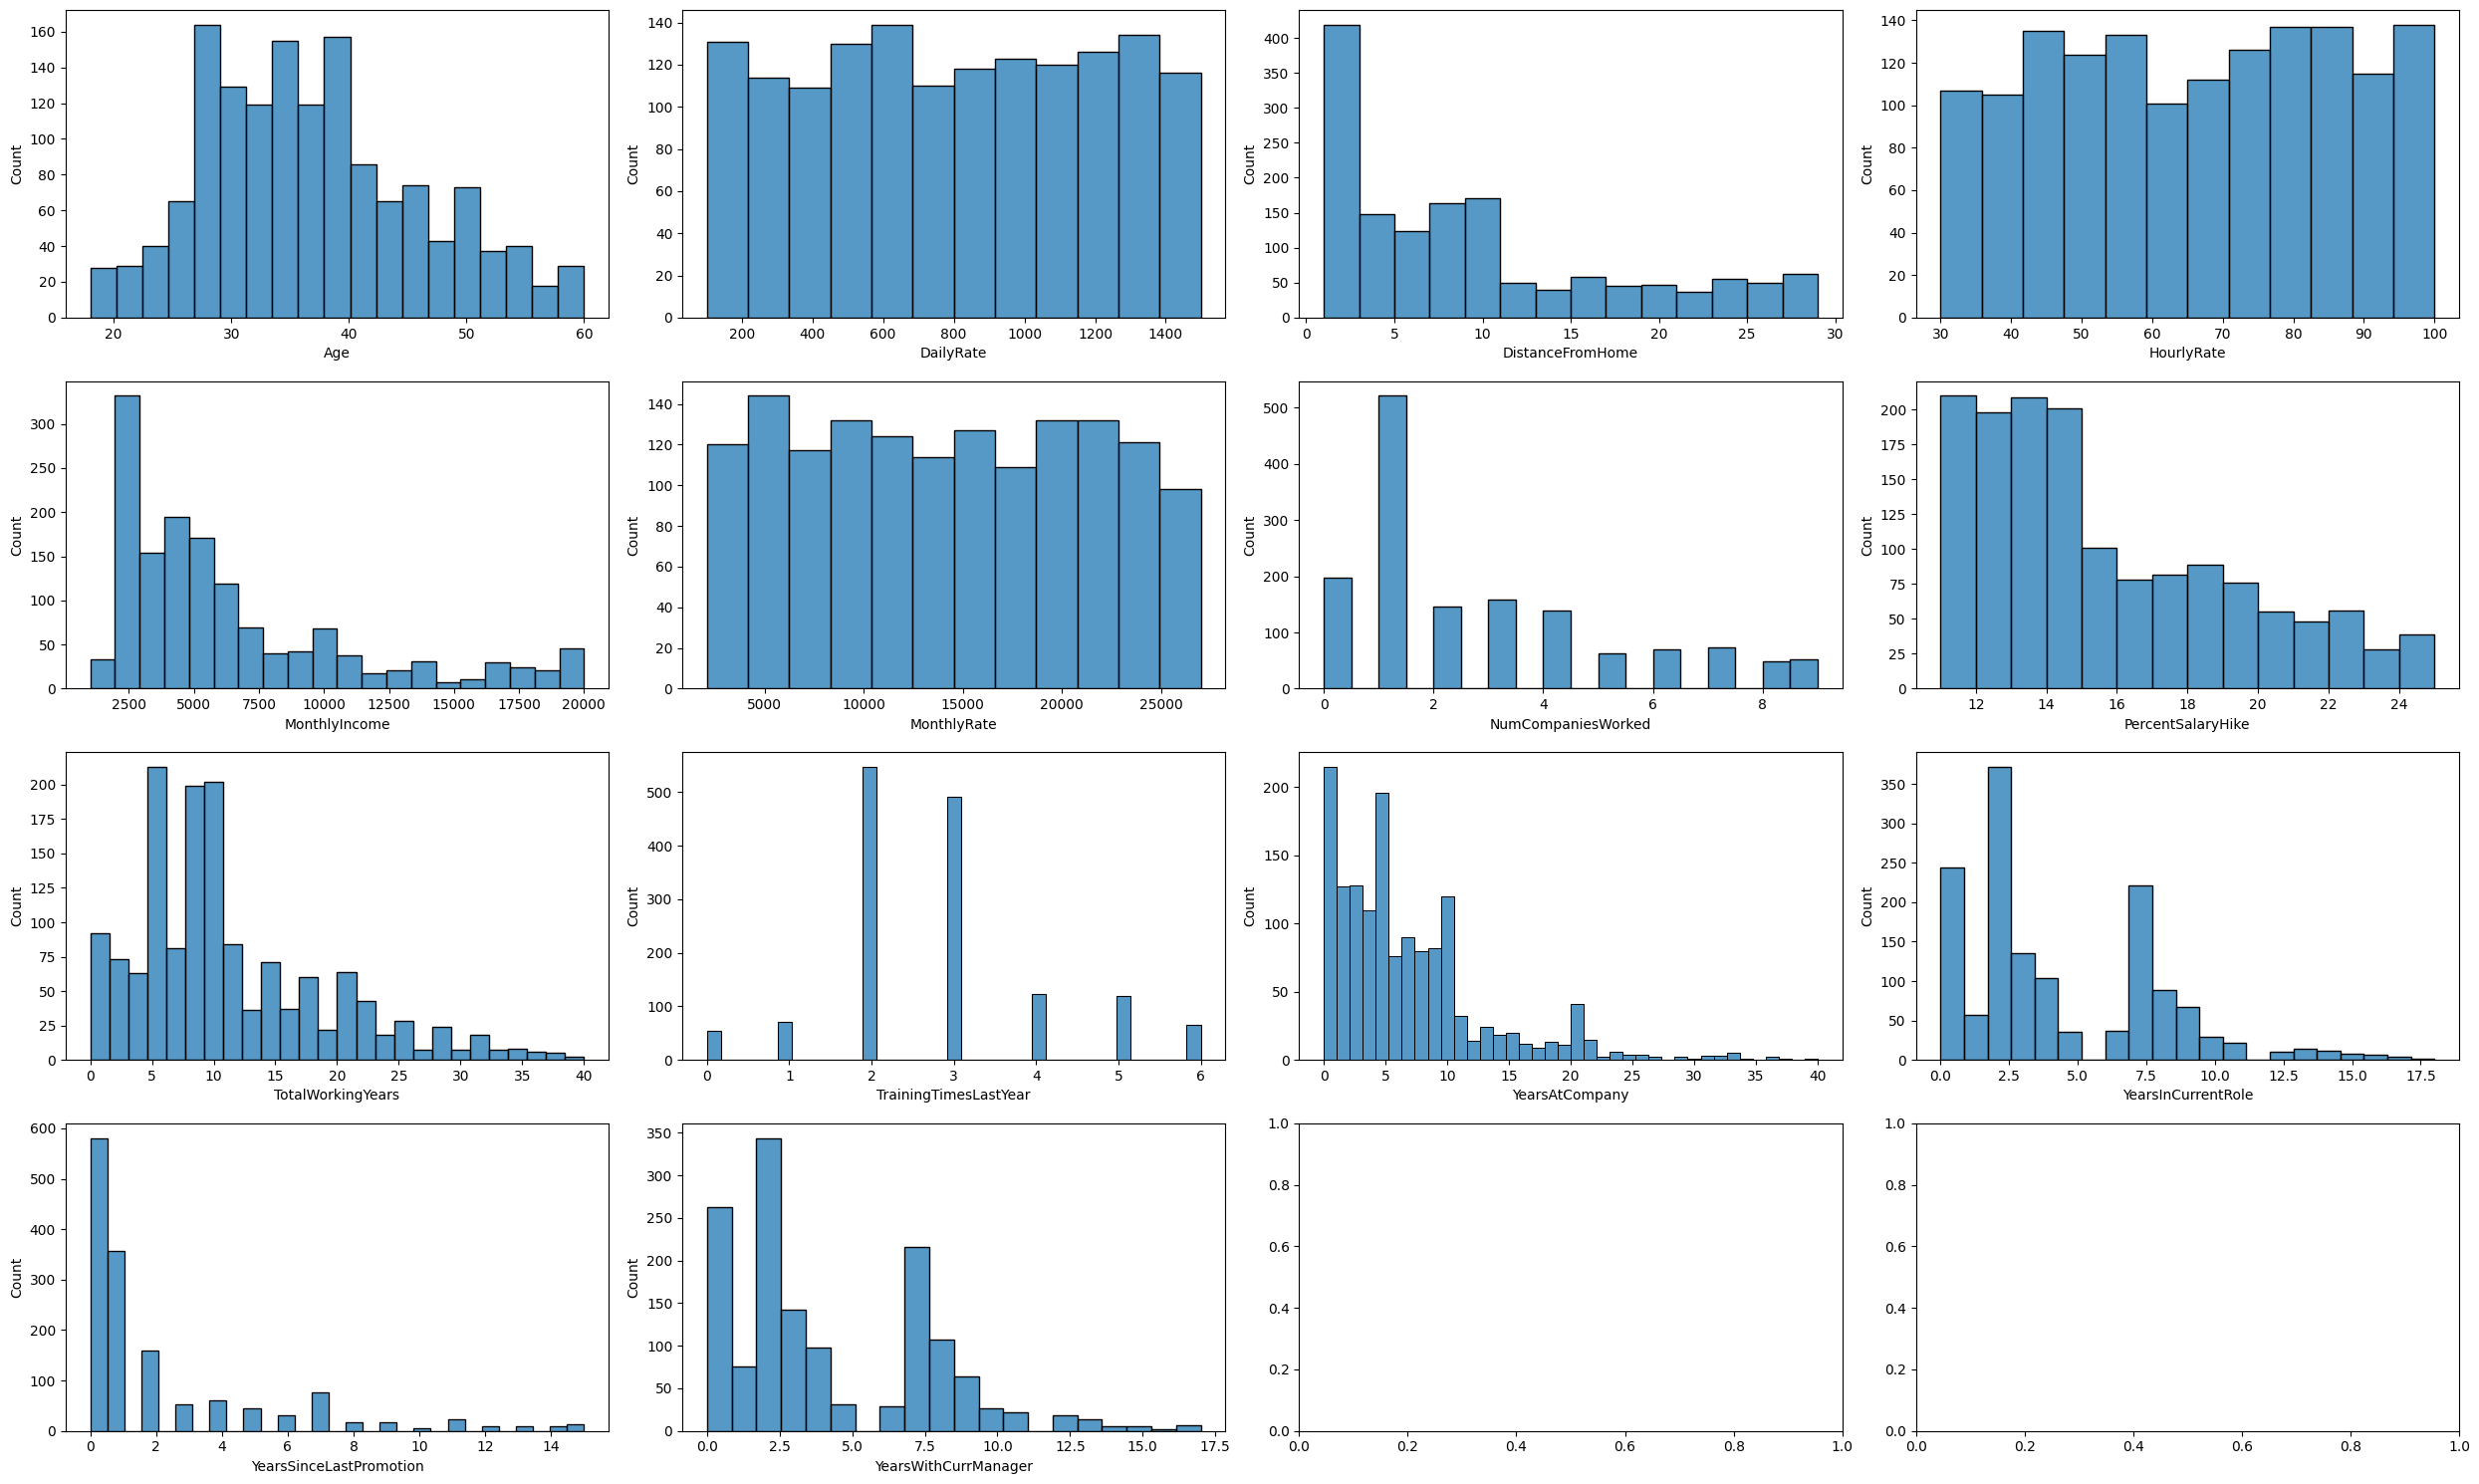

['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [54]:
cum=[]
fig,axs=plt.subplots(4,4,figsize=(25,15))
axs=axs.flatten()
for i,column in enumerate(con_df.columns) :
    sns.histplot(x=column,data=df,ax=axs[i])
    cum.append(column)
fig.tight_layout()
plt.show()
print(cum)


<Axes: xlabel='Attrition'>

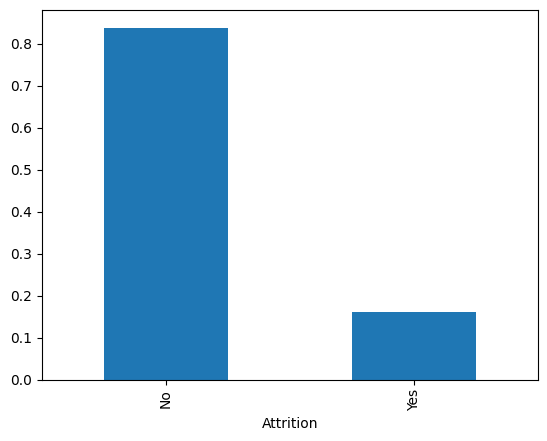

In [55]:
df['Attrition'].value_counts(normalize=True).plot(kind='bar')

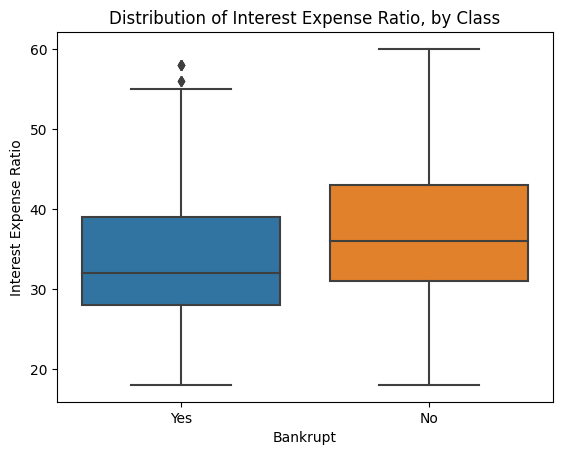

In [56]:
# Create boxplot
sns.boxplot(y='Age',x='Attrition',data=df)
plt.xlabel("Bankrupt")
plt.ylabel("Interest Expense Ratio")
plt.title("Distribution of Interest Expense Ratio, by Class");

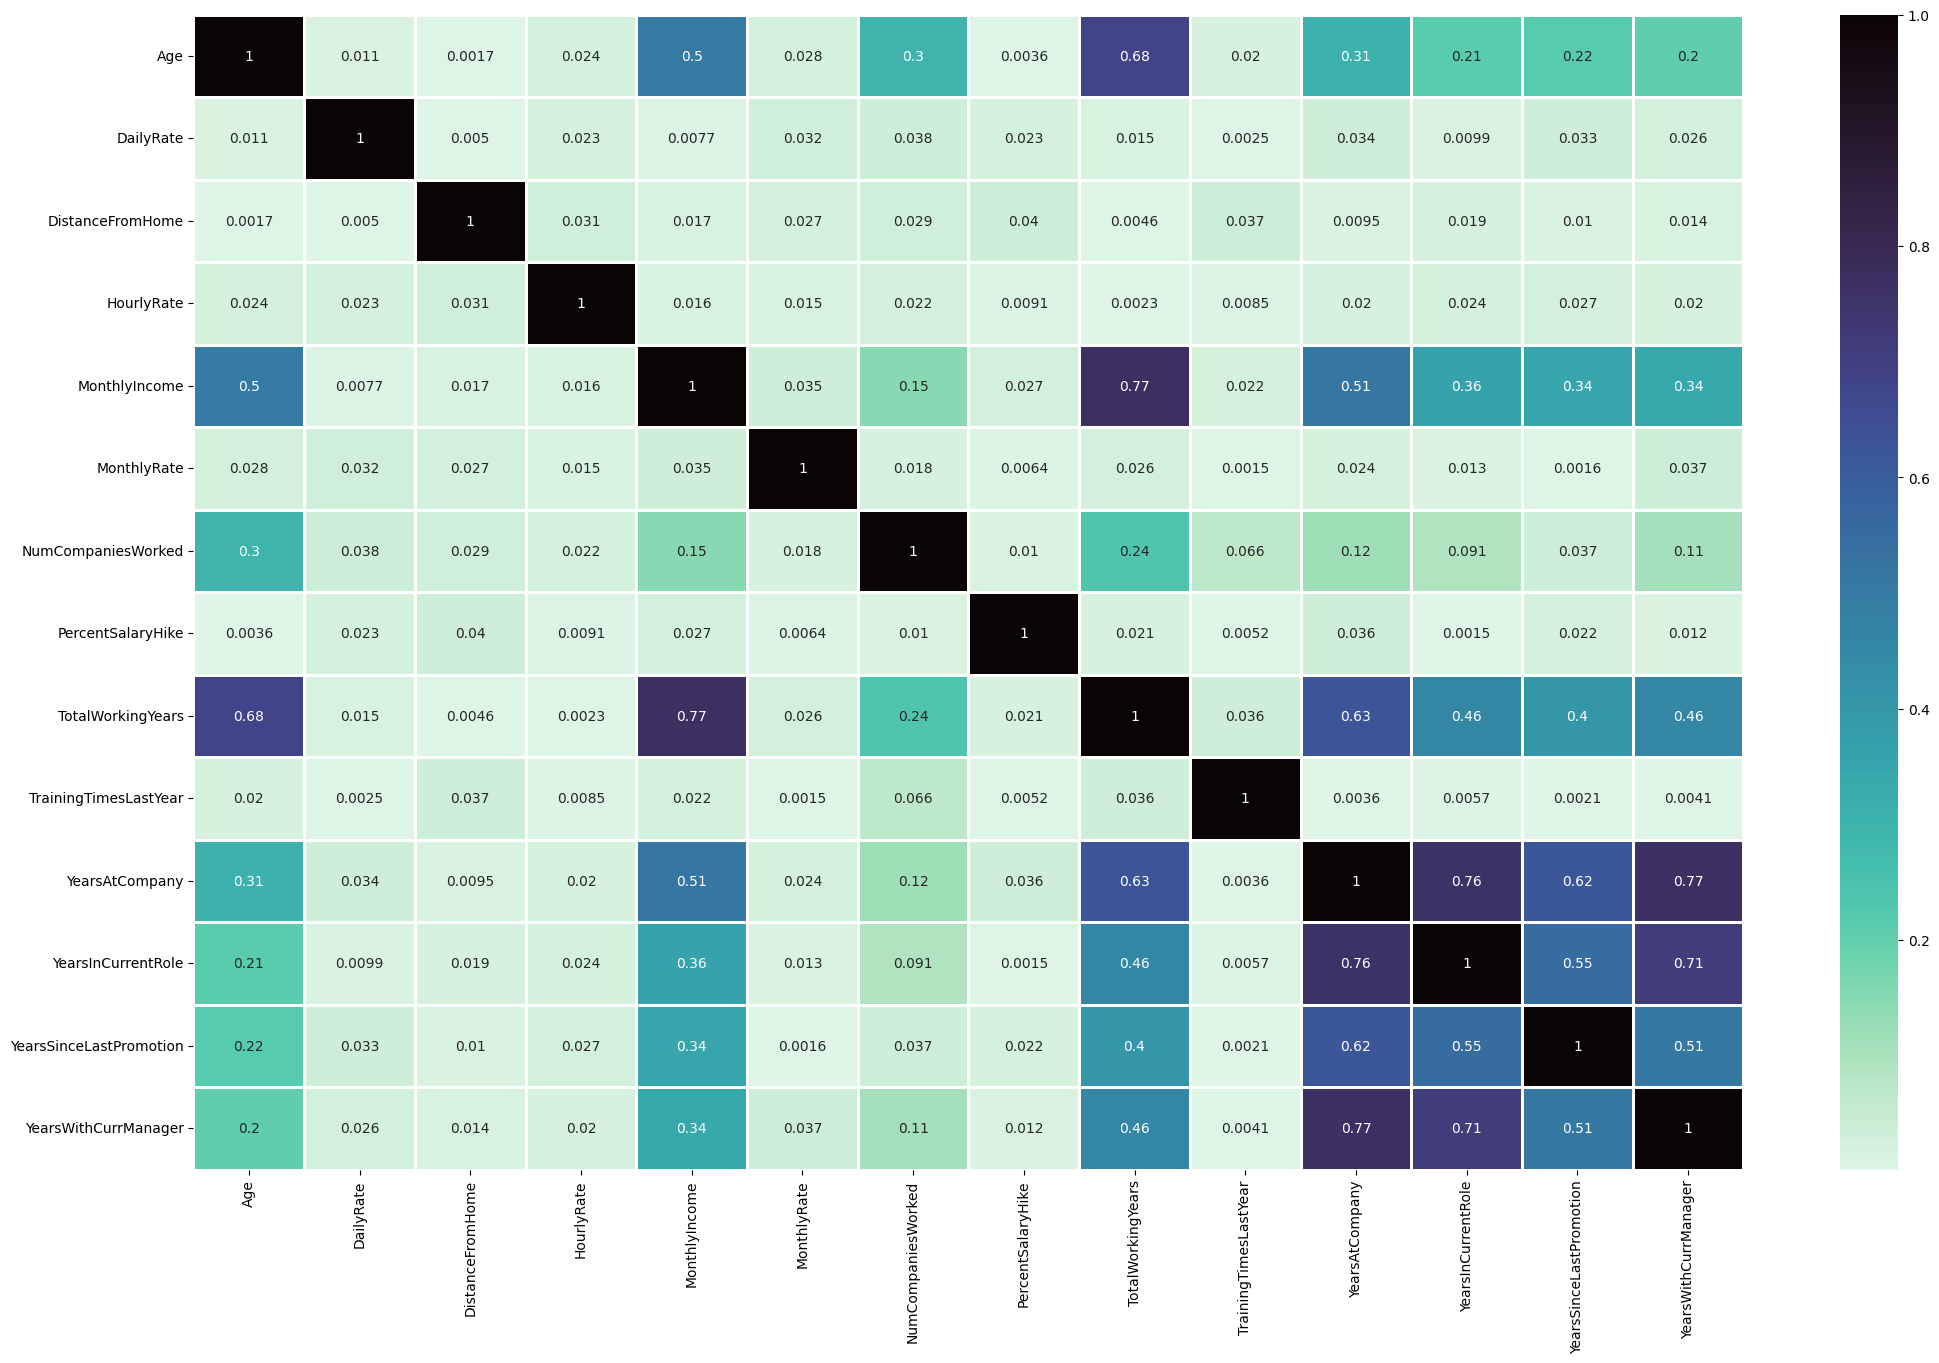

In [57]:
corr=con_df.corr().abs()
plt.figure(figsize = (25,15))

ax = sns.heatmap(corr, annot=True, linewidths=1,cmap='mako_r')

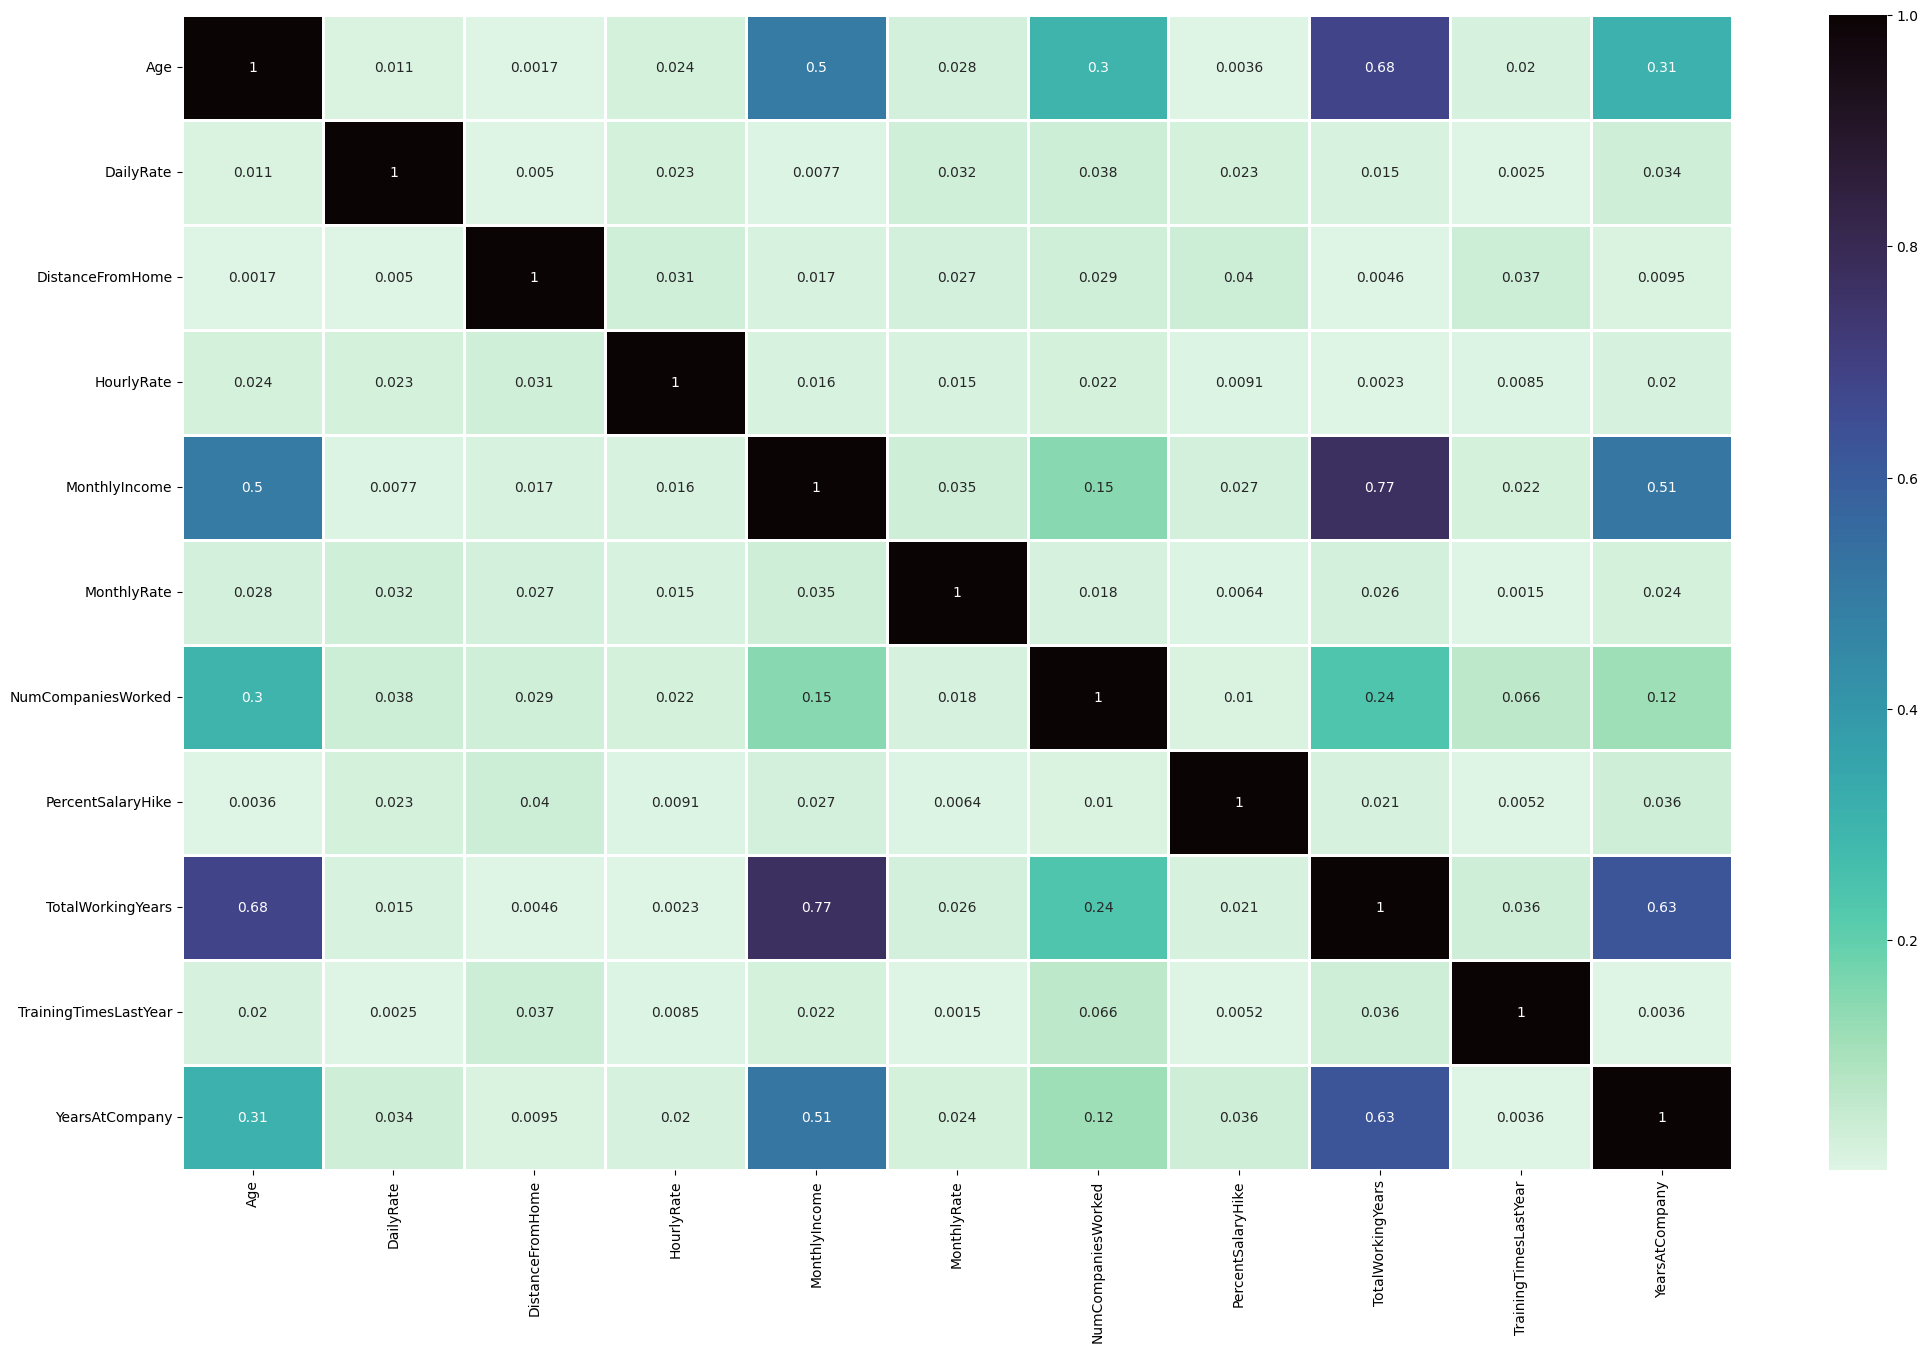

In [59]:
drop_corr=['YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
co=con_df.drop(columns=drop_corr).corr().abs()
plt.figure(figsize = (25,15))

ax = sns.heatmap(co, annot=True, linewidths=1,cmap='mako_r')

## Skewed Data

In [60]:

sk=[]
for i in df.drop(columns=drop_cat+target+drop_id+drop_corr).columns:
    if ((df[i].skew()>1) or (df[i].skew()<-1)):
        sk.append(i)
sk

['MonthlyIncome', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsAtCompany']

In [61]:
# update values of skew data from x to log(x)
np.seterr(divide = 'ignore') 
sk_=pd.DataFrame(np.select([df[sk]==0, df[sk] > 0, df[sk] < 0], [0, np.log(df[sk]), np.log(df[sk])]),columns=sk).set_index(df.index)
df_skew=df.drop(columns=sk).set_index(df.index)

df_skew=pd.concat([df_skew,sk_],axis=1)
X_skew=df_skew.drop(columns='Attrition')

# Split

In [62]:
# instantiate labelencoder object
le = LabelEncoder()

X = df_skew.drop(columns=target+drop_id+drop_corr)
y = le.fit_transform( np.ravel(df[target]))
#y=df[target].values
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1470, 27)
y shape: (1470,)


In [63]:
y

array([1, 0, 1, ..., 0, 0, 0])

In [64]:
one_hot_encoded_X = pd.get_dummies(X, columns = drop_cat)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_X,y,test_size=0.2,random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1176, 75)
y_train shape: (1176,)
X_test shape: (294, 75)
y_test shape: (294,)


# Resample

In [66]:
under_sampler =RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
print(X_train_under.shape)
X_train_under.head()

(396, 75)


,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyRate,PercentSalaryHike,TrainingTimesLastYear,MonthlyIncome,NumCompaniesWorked,TotalWorkingYears,...,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
1084,34,971,1,64,12288,14,3,8.865453,0.000000,2.302585,...,True,False,False,False,False,False,False,False,True,False
1412,30,911,1,76,4077,13,6,8.228978,0.000000,2.484907,...,False,False,False,True,False,False,False,False,False,False
756,32,1109,29,69,11135,12,2,8.300280,2.197225,2.302585,...,False,False,False,True,False,False,False,False,False,False
1446,34,704,28,95,8978,21,2,8.811652,0.000000,2.079442,...,False,False,False,False,False,False,False,False,True,False
1121,36,884,1,73,21447,13,5,8.826881,1.791759,2.708050,...,False,False,False,False,False,False,False,False,True,False


In [67]:
#then over sampler
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(1956, 75)


,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyRate,PercentSalaryHike,TrainingTimesLastYear,MonthlyIncome,NumCompaniesWorked,TotalWorkingYears,...,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,24,350,21,57,10036,14,3,7.738924,0.000000,0.693147,...,True,False,False,True,False,False,False,False,False,False
1,18,287,5,73,13493,15,2,6.957497,0.000000,0.000000,...,False,False,False,False,False,False,False,True,False,False
2,29,1247,20,45,10732,14,2,8.843759,0.693147,2.302585,...,False,False,False,False,False,False,False,False,True,False
3,39,492,12,66,7693,21,3,8.574518,1.386294,1.945910,...,False,False,False,False,False,True,False,False,False,False
4,31,311,20,89,18624,11,2,8.342125,0.000000,2.302585,...,False,False,False,True,False,False,False,False,False,False


# Build Model

## base line

## Iterate

## 1- LogisticRegression

### Hyper parameter Tuning

In [68]:

clf_LogisticRegression=make_pipeline(StandardScaler(),LogisticRegression())
parameters = [    
    {'logisticregression__penalty' : ['l1', 'l2', 'elasticnet'],   
    'logisticregression__C' : [1e-5, 1e-4, 1e-3, 1, 10, 100, ] ,                      
    'logisticregression__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],  
    'logisticregression__max_iter' : [100, 1000,2500, 5000,10000]               
    }
]

In [82]:
tuning_model=GridSearchCV(clf_LogisticRegression,param_grid=parameters,cv=3,verbose=True,scoring= 'accuracy')
tuning_model_over=GridSearchCV(clf_LogisticRegression,param_grid=parameters,cv=3,verbose=True,scoring= 'accuracy')

In [70]:

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

## Fit te best params 

In [77]:
tuned_hyper_model= make_pipeline(StandardScaler(),LogisticRegression(C=1,penalty='l1',solver= 'liblinear',max_iter=100))
tuned_hyper_model_over= make_pipeline(StandardScaler(),LogisticRegression(C=1,penalty='l1',solver= 'liblinear',max_iter=100))

In [78]:
tuned_hyper_model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, penalty='l1', solver='liblinear'))])

In [79]:

tuned_hyper_model_over.fit(X_train_over,y_train_over)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, penalty='l1', solver='liblinear'))])

## Evaluate 

In [80]:
for m in [tuned_hyper_model, tuned_hyper_model_over]:
    acc_train = m.score(X_train,y_train)
    acc_test = m.score(X_test,y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9005
Test Accuracy: 0.8912
Training Accuracy: 0.8146
Test Accuracy: 0.7653


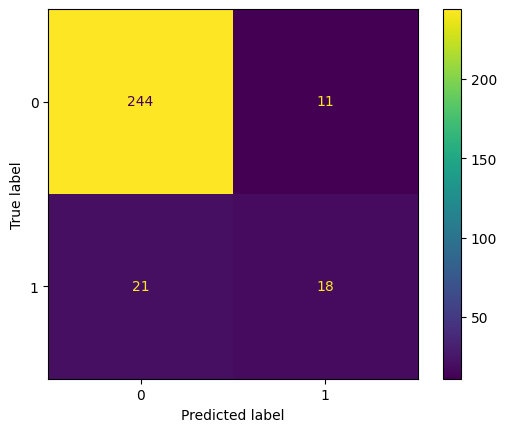

In [81]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(tuned_hyper_model,X_test,y_test)